In [1]:
import re
import ast
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime

import matplotlib.pyplot as plt 
from pylab import rcParams

from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, hamming_loss

%matplotlib inline

In [2]:
nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Load Dataset

In [3]:
file_path = 'D:\\MyNoteBook\\movie_genre_data\\movie_genre_data.tsv'

In [4]:
df = pd.read_csv(file_path, sep='\t', usecols=['plot', 'movie_name', 'genre'])

# Exploratory Data Analysis

In [5]:
df.head(5)

,plot,movie_name,genre
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"['Drama', 'World cinema']"
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"['Action/Adventure', 'Science Fiction', 'Action', 'Drama']"
2,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"['Musical', 'Action', 'Drama', 'Bollywood']"
3,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"['Screwball comedy', 'Comedy']"
4,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"['Crime Fiction', 'Drama', 'Docudrama', 'World cinema', 'Courtroom Drama']"


In [6]:
# check dimensionality of the DataFrame (rows and columns)

df.shape

(42204, 3)

In [7]:
# check and detect missing values in the dataset

df.isnull().sum()

# df.isna().any()

plot          0
movie_name    0
genre         0
dtype: int64

In [8]:
# prints information about the DataFrame.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42204 entries, 0 to 42203
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   plot        42204 non-null  object
 1   movie_name  42204 non-null  object
 2   genre       42204 non-null  object
dtypes: object(3)
memory usage: 989.3+ KB


In [9]:
# detect duplicate rows

df.duplicated().sum()

2

In [10]:
# drop duplicate rows

df.drop_duplicates(inplace=True)

In [11]:
# dropna() is used to remove a row or a column from a dataframe that has a NaN or missing values in it.

df.dropna(inplace=True)
df.isnull().sum()

plot          0
movie_name    0
genre         0
dtype: int64

In [12]:
df.shape

(42202, 3)

### Here genre column (type) values in string form so we need to convert into list object

In [13]:
type(df.iloc[0]['genre'])

str

In [14]:
df.iloc[0]['genre']

"['Drama', 'World cinema']"

In [15]:
ast.literal_eval(df.iloc[0]['genre'])[0]

'Drama'

In [16]:
# We will use ast.literal_eval() method in order to get actual object from string representation 
# evaluates the string, and gets the python list object.

df['genre'] = df['genre'].apply(lambda x: ast.literal_eval(x))

In [17]:
df.head(2)

,plot,movie_name,genre
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]"
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]"


In [18]:
df.iloc[0]['genre']

['Drama', 'World cinema']

In [19]:
df.shape

(42202, 3)

### Remove samples with 0 genre tags

In [20]:
df = df[~(df['genre'].str.len() == 0)]

In [21]:
df.shape

(41791, 3)

### Get all unique genre tags in a list

In [22]:
all_genres = [] 

# extract genres
for ge in df['genre']: 
    for g in ge:
        all_genres.append(g)

In [23]:
len(set(all_genres))

363

### Most Frequent Genre

In [24]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

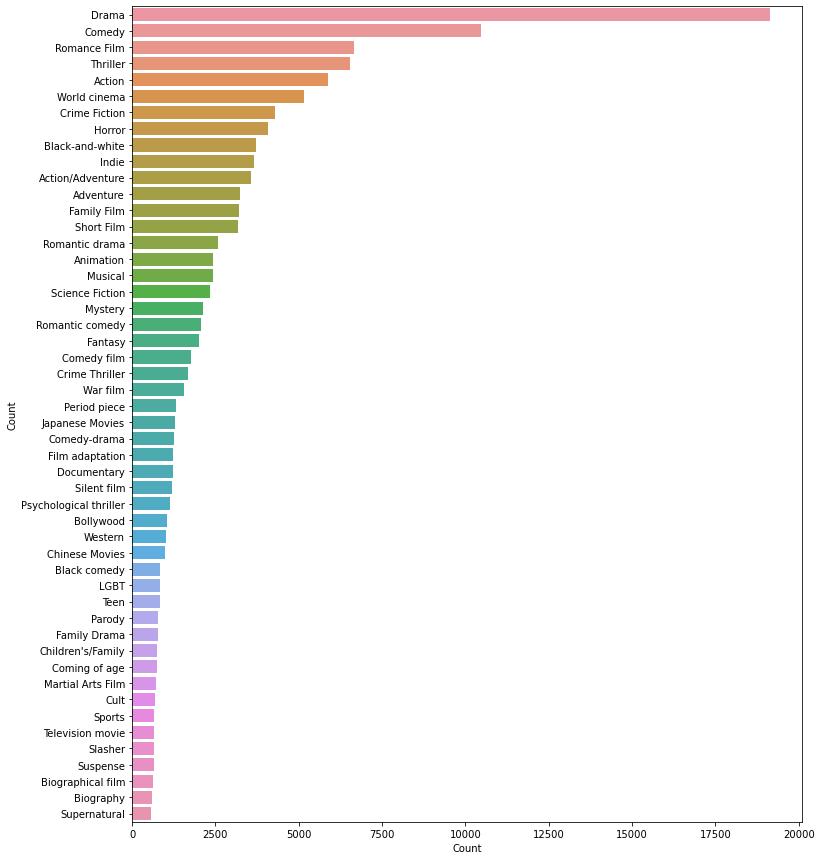

In [25]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre", orient="h") 
ax.set(ylabel = 'Count') 
plt.show()

# Text Preprocessing 

## Create a function to clean the text

    Normalize Text
    Remove Unicode Characters
    Remove Stopwords
    Perform Stemming and Lemmatization

In [26]:
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

# function for text cleaning 
def clean_text(text):
    
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    # remove whitespaces 
    text = ' '.join(text.split()) 
    
    # convert text to lowercase 
    text = text.lower() 
    
    # remove stop words
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    text = ' '.join(no_stopword_text)
    
    stemmed_plot = [porter.stem(word) for word in text.split()]
    text = ' '.join(stemmed_plot)
    
    return text

# Clean up plot column

In [27]:
%timeit

df['clean_plot'] = df['plot'].apply(lambda x: clean_text(x))

In [28]:
df['clean_plot'][0]

'shlykov hard work taxi driver lyosha saxophonist develop bizarr love hate relationship despit prejudic realiz arent differ'

### Visualize the Most Frequent Words in the Movie Plots Column

In [29]:
def freq_words(x, terms=30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

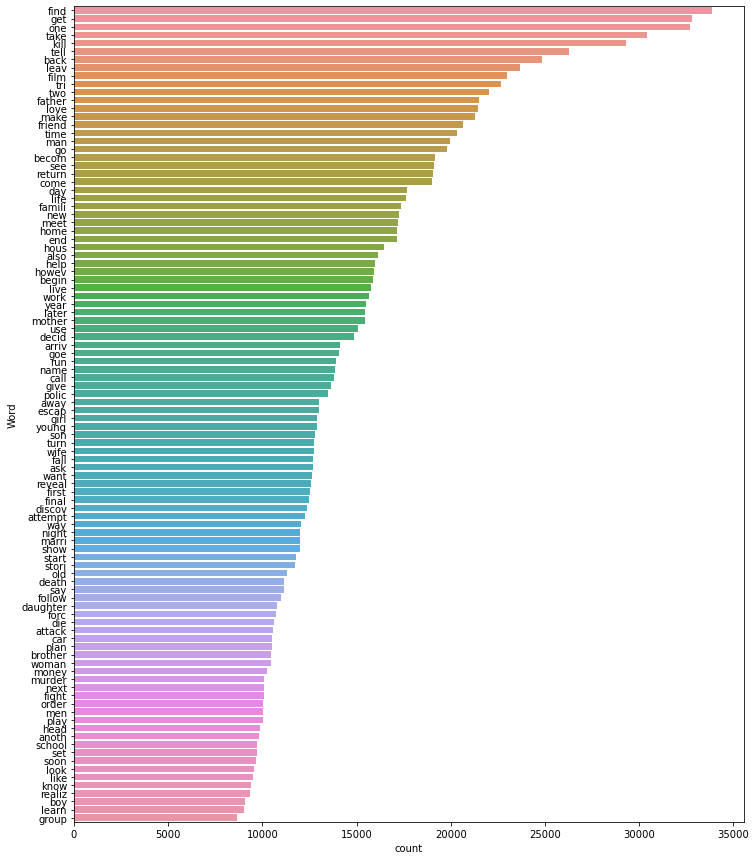

In [30]:
# print 100 most frequent words
    
freq_words(df['clean_plot'], 100)

In [31]:
df.head()

,plot,movie_name,genre,clean_plot
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",shlykov hard work taxi driver lyosha saxophonist develop bizarr love hate relationship despit prejudic realiz arent differ
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",nation panem consist wealthi capitol twelv poorer district punish past rebellion district must provid boy girl age select lotteri annual hunger game tribut must fight death arena sole survivor reward fame wealth first reap year old primros everdeen chosen district older sister katniss volunt tak...
2,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]",pooval induchoodan sentenc six year prison life murder classmat induchoodan son justic marancheri karunakara menon frame case manap madhavan nambiar croni dysp sankaranarayanan take reveng idealist judg menon earlier given jail sentenc manap corrupt case induchoodan achiev top rank indian civil ...
3,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"[Screwball comedy, Comedy]",lemon drop kid new york citi swindler illeg tout hors florida racetrack sever success hustl kid come across beauti gullibl woman intend bet lot money kid convinc switch bet employ prefabr con unfortun kid woman belong notori gangster moos moran money kid choic finish dead last furiou moran deman...
4,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]",seventh day adventist church pastor michael chamberlain wife lindi two son nine week old daughter azaria camp holiday outback babi sleep tent famili enjoy barbecu fellow camper cri heard lindi return tent check azaria certain see dingo someth mouth run approach discov infant miss everyon join fo...


## Converting String genre to Multi Lable output variables

    This is Multi-Label Classification problem as a Binary Relevance problem. 
    Hence, we will now one hot encode the target variable, i.e., new_genre by using sklearn’s MultiLabelBinarizer(). 
    Since there are 363 unique genre tags, there are going to be 363 new target variables.
    
    When we train our model we'll provide the labels (in this case genres) associated with each movie. 
    We can't pass the genres in as strings directly, we'll transform them into multi-hot vectors. 
    Since we have 363 genres, we'll have a 363 element vector for each movie 
    with 0s and 1s indicating which genres are present in each description.

In [32]:
encoder = MultiLabelBinarizer()

y = encoder.fit_transform(df['genre']) # multi onehot encoder

In [33]:
y.shape

(41791, 363)

In [34]:
classes = encoder.classes_

In [35]:
classes

array(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy', 'Airplanes and airports',
       'Albino bias', 'Alien Film', 'Alien invasion', 'Americana',
       'Animal Picture', 'Animals', 'Animated Musical',
       'Animated cartoon', 'Animation', 'Anime', 'Anthology',
       'Anthropology', 'Anti-war', 'Anti-war film',
       'Apocalyptic and post-apocalyptic fiction', 'Archaeology',
       'Archives and records', 'Art film', 'Auto racing', 'Avant-garde',
       'B-Western', 'B-movie', 'Backstage Musical', 'Baseball',
       'Beach Film', 'Beach Party film', 'Bengali Cinema', 'Biker Film',
       'Biographical film', 'Biography', 'Biopic [feature]',
       'Black comedy', 'Black-and-white', 'Blaxploitation',
       'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance',
       'British Empire Film', 'British New Wave', 'Bruceploitation',
       'Buddy Picture

In [36]:
# there are going to be 363 new target variables

classes.shape

(363,)

## Spliting the dataset

    First, we need to divide our data into features (X) and labels (y). 
    The dataframe gets divided into X_train, X_test, y_train, and y_test. 
    X_train and y_train sets are used for training and fitting the model.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_plot'], y, test_size=0.2, random_state=5, shuffle=True)

In [38]:
X_train.shape, X_test.shape

((33432,), (8359,))

In [39]:
y_train.shape, y_test.shape

((33432, 363), (8359, 363))

## Featurizing plots with TfIdf vectorizer

#### To Extracting features from the cleaned version of the movie plots data.

    I will be using TF-IDF features. 
    We can use other feature extraction methods such as :
    
        Bag-of-Words, 
        word2vec, 
        GloVe.

In [40]:
# Train Test and call evaluate method
def train_test_evaluate_model(xtrain, ytrain, xtest, ytest, classifier):
    
    # Pipeline with TF-IDF for feature extraction and OvsR for classification with classifier
    
    # Scikit-learn provides a Pipeline utility to help automate machine learning workflows. 
    # Pipelines are very common in Machine Learning systems, 
    # Since there is a lot of data to manipulate and many data transformations to apply. 
    # So we will utilize pipeline to train every classifier.


    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word', max_features=10000, max_df=0.8, 
                                                    ngram_range=(1,3), stop_words='english')),
        ('classifier', OneVsRestClassifier(classifier))
    ])
    
    
    # Here hyperparameter tweaking technique is used in grid search to find the optimal hyperparameters,so that we can obtain
    # optimal set values for model parameter
    # we are not using it beacuse its taking a long time to execute
    
    """
    parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
              'tfidf__use_idf': (True, False),
              'tfidf__max_df': [0.25, 0.5, 0.75, 1.0],
              'tfidf__max_features': [10, 50, 100, 250, 500, 1000, None],
              'tfidf__stop_words': ('english', None),
              'tfidf__smooth_idf': (True, False),
              'tfidf__norm': ('l1', 'l2', None),
              }

    grid = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=2, verbose=1, scoring='accuracy', n_jobs=-1)
    
    grid = grid.fit(xtrain, ytrain)
    
    
    print(grid.best_score)
    
    print(grid.best_params_)
    
    clf = grid.best_estimator
    
    clf.fit(xtrain, ytrain)
    
    print('Test Accuracy : %.3f' % clf.score(xtest, ytest))
    
    """
    
    # Fit the data
    pipeline.fit(xtrain, ytrain)
        
    # Predict on test
    y_pred = pipeline.predict(xtest)
    
    # Evaluate performance
    evaluate_classifier(ytest, y_pred)
    
    return pipeline, y_pred

## Create a function to evaluate classifier

In [41]:
def evaluate_classifier(ground_truth, pred):
    
    accuracy = accuracy_score(ground_truth, pred) * 100
    recall = recall_score(ground_truth, pred, average='micro') * 100
    precision = precision_score(ground_truth, pred, average='micro', zero_division=1) * 100
    f1 = f1_score(ground_truth, pred, average='micro', zero_division=1) * 100
    weighted_f1 = f1_score(ground_truth, pred, average='weighted', zero_division=1) * 100
    
    
    print('Accuracy =     ', round(accuracy, 2), "%")
    print('Recall =       ', round(recall, 2), '%')
    print('Precision =    ', round(precision, 2), '%')
    
    print('F1 Score =     ', round(f1, 2), '%')
    print('Weighted F1 Score =     ', round(f1, 2), '%')

In [42]:
# To evaluate our models, I'll use the jacard score since it's the best fitted for multi-label classification


def avg_jacard(y_true,y_pred):
    
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))

## Create a function to predict genre of the movies plot

In [43]:
def infer_genre(q, pipeline):
    q_vec = pipeline.named_steps['tfidf'].transform([q])
    q_pred = pipeline.named_steps['classifier'].predict(q_vec)
    return encoder.inverse_transform(q_pred)

# Model Building

In [44]:
# Classifiers

support_vector_classifier = LinearSVC(C=1.5, penalty='l2', dual=False)

lr_classifier = LogisticRegression(random_state=0, max_iter=10000)

multinomial_bayes = MultinomialNB(fit_prior=True, class_prior=None)

## Linear Support Vector Classifier

In [45]:
# Train Test and Evaluate LinearSVC Model
pipeline, predictions = train_test_evaluate_model(xtrain=X_train, ytrain=y_train, xtest=X_test, 
                          ytest=y_test, classifier=support_vector_classifier)

Accuracy =      5.93 %
Recall =        30.95 %
Precision =     56.01 %
F1 Score =      39.87 %
Weighted F1 Score =      39.87 %


In [46]:
print_score(predictions, pipeline.steps[1])

Clf:  tuple
Jacard score: 28.058756784680938
Hamming loss: 0.9263369647930654


### Make prediction on Test data

In [47]:
for i in range(5): 
    k = X_test.sample(1).index[0] 
    print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_genre(X_test[k], pipeline))
    print("Actual genre: ", df['genre'][k], "\n")

Movie:  Suryavamsam 
Predicted genre:  [('Action', 'Drama')]
Actual genre:  ['Drama'] 

Movie:  Anjali 
Predicted genre:  [('Drama',)]
Actual genre:  ['Musical', 'Family Drama', 'Tamil cinema'] 

Movie:  Slaughterhouse Rock 
Predicted genre:  [('Horror',)]
Actual genre:  ['Horror', 'Comedy', 'Horror Comedy'] 

Movie:  On the Town 
Predicted genre:  [('Black-and-white', 'Comedy', 'Drama', 'Indie', 'LGBT', 'Romance Film', 'Romantic comedy')]
Actual genre:  ['Musical'] 

Movie:  The Amazing Spiderman 
Predicted genre:  [('Comedy', 'Superhero movie')]
Actual genre:  ['Crime Fiction', 'Science Fiction', 'Superhero movie', 'Drama', 'Fantasy', 'Family Film', 'Action'] 



## Linear Regression Classifier

In [48]:
# Train Test and Evaluate LinearSVC Model
pipeline, predictions = train_test_evaluate_model(xtrain=X_train, ytrain=y_train, 
                          xtest=X_test, ytest=y_test, classifier=lr_classifier)

Accuracy =      7.67 %
Recall =        20.93 %
Precision =     69.32 %
F1 Score =      32.15 %
Weighted F1 Score =      32.15 %


In [49]:
print_score(predictions, pipeline.steps[1])

Clf:  tuple
Jacard score: 23.815149771603895
Hamming loss: 0.8764740137566378


### Make prediction on Test data

In [50]:
for i in range(5): 
    k = X_test.sample(1).index[0] 
    print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_genre(X_test[k], pipeline))
    print("Actual genre: ", df['genre'][k], "\n")

Movie:  Le fantôme de la liberté 
Predicted genre:  [('Drama',)]
Actual genre:  ['Surrealism', 'Drama', 'Comedy', 'World cinema', 'Art film'] 

Movie:  Dreamkiller 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Mystery'] 

Movie:  Satyricon 
Predicted genre:  [('Drama', 'World cinema')]
Actual genre:  ['LGBT', 'Romantic comedy', 'Drama', 'Art film', 'World cinema'] 

Movie:  Veerabhadra 
Predicted genre:  [()]
Actual genre:  ['Action'] 

Movie:  Vishwanatha Nayakudu 
Predicted genre:  [('Drama',)]
Actual genre:  ['Action', 'Drama', 'Historical drama'] 



## Multinomial Bayes Classifier

In [51]:
# Train Test and Evaluate Multinomial Bayes Model
pipeline, predictions = train_test_evaluate_model(xtrain=X_train, ytrain=y_train, 
                          xtest=X_test, ytest=y_test, classifier=multinomial_bayes)

Accuracy =      6.89 %
Recall =        15.23 %
Precision =     68.53 %
F1 Score =      24.92 %
Weighted F1 Score =      24.92 %


In [52]:
print_score(predictions, pipeline.steps[1])

Clf:  tuple
Jacard score: 18.963755734900605
Hamming loss: 0.9105179188594995


### Make prediction on Test data

In [53]:
for i in range(5): 
    k = X_test.sample(1).index[0] 
    print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_genre(X_test[k], pipeline))
    print("Actual genre: ", df['genre'][k], "\n")

Movie:  Annibale 
Predicted genre:  [('Drama',)]
Actual genre:  ['Action', 'Drama', 'Adventure'] 

Movie:  Voices Within: The Lives of Truddi Chase 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama'] 

Movie:  Love Me Tonight 
Predicted genre:  [('Drama',)]
Actual genre:  ['Romantic comedy', 'Operetta', 'Black-and-white', 'Musical', 'Pre-Code', 'Comedy', 'Romance Film'] 

Movie:  Rare Melodies 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama', 'Tamil cinema'] 

Movie:  LollyPop 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama'] 



## Save Model

In [54]:
import joblib

In [55]:
joblib.dump(pipeline, 'classifiers.pkl', compress=1)

['classifiers.pkl']

## Load Model

In [56]:
joblib.load('classifiers.pkl')

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=10000,
                                 ngram_range=(1, 3), stop_words='english')),
                ('classifier', OneVsRestClassifier(estimator=MultinomialNB()))])

In [57]:
clf = joblib.load('classifiers.pkl')

In [58]:
for i in range(5): 
    k = X_test.sample(1).index[0] 
    print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_genre(X_test[k], clf))
    print("Actual genre: ", df['genre'][k], "\n")

Movie:  Cargo 
Predicted genre:  [('Science Fiction',)]
Actual genre:  ['Thriller', 'Mystery', 'Science Fiction'] 

Movie:  The Lucky Guy 
Predicted genre:  [()]
Actual genre:  ['Romantic comedy', 'Drama', 'Comedy', 'Chinese Movies'] 

Movie:  Anyay Abichar 
Predicted genre:  [('Action', 'Drama')]
Actual genre:  ['Action'] 

Movie:  Once Upon a Time 
Predicted genre:  [()]
Actual genre:  ['Science Fiction', 'Japanese Movies', 'World cinema', 'Animation', 'Anime', 'Fantasy', 'Drama', 'Steampunk'] 

Movie:  Chased 
Predicted genre:  [()]
Actual genre:  ['Short Film'] 

